# PortfolioOptimiser.jl

This is a demo/template for using `PortfolioOptimiser.jl`. It should be all that you need to start to use and adapt the library to your needs.

In [1]:
using PortfolioOptimiser
using CSV, DataFrames, Plots, StatsBase, LinearAlgebra

## Loading data

All our functions take AbstractArray or Tuple arguments, not DataFrame or TimeArray data. The reason is to keep the code as generic and performant as possible. Julia is fast enough that it can be used in performance critical applications, so we remove the data wrangling from the equation, and we leave it up to the user to decide how they want to handle their data.

For the example we'll use CSV and DataFrames to load our historical prices.

In [2]:
hist_prices = CSV.read("./assets/stock_prices.csv", DataFrame)
dropmissing!(hist_prices)

896×21 DataFrame
 Row │ date        GOOG      AAPL      FB       BABA     AMZN     GE       AMD ⋯
     │ Date        Float64   Float64   Float64  Float64  Float64  Float64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2014-09-19   592.82    94.7721    77.91    93.89   331.32  23.421       ⋯
   2 │ 2014-09-22   584.158   94.866     76.8     89.89   324.5   23.2339
   3 │ 2014-09-23   577.952   96.3492    78.29    87.17   323.63  23.1805
   4 │ 2014-09-24   584.775   95.5137    78.54    90.57   328.21  23.1003
   5 │ 2014-09-25   571.915   91.8715    77.22    88.92   321.93  22.7618      ⋯
   6 │ 2014-09-26   573.944   94.575     78.79    90.46   323.21  22.833
   7 │ 2014-09-29   573.208   93.9743    79.0     88.75   321.82  22.646
   8 │ 2014-09-30   574.203   94.575     79.04    88.85   322.44  22.8241
  ⋮  │     ⋮          ⋮         ⋮         ⋮        ⋮        ⋮        ⋮         ⋱
 890 │ 2018-04-03  1013.41   168.39     156.11   174.67  1392.05  13.13        ⋯
 891 │ 2018-04-04  1025.14   171.61     155.1    172.07  1410.57  13.28
 892 │ 2018-04-05  1027.81   172.8      159.34   172.57  1451.75  13.43      1
 893 │ 2018-04-06  1007.04   168.38     157.2    167.52  1405.23  13.06
 894 │ 2018-04-09  1015.45   170.05     157.93   169.87  1406.08  12.83        ⋯
 895 │ 2018-04-10  1031.64   173.25     165.04   177.1   1436.22  13.05
 896 │ 2018-04-11  1019.97   172.44     166.32   175.36  1427.05  12.97
                                                 14 columns and 881 rows omitted

## Returns

`PortfolioOptimiser.jl` calculates a variety of returns and expected returns. First we have to load the data. In this case, we load daily stock data pertaining to a variety of different tickers into a DataFrame.

The price data is pretty useless until we want to allocate our portfolio, what we want for our calculations need is the return data. We can get both regular and log returns with the function `returns_from_prices`. Log returns are useful because they can be added instead of multiplied when compounding, the function defaults to regular returns.

In [3]:
returns = returns_from_prices(hist_prices[!, 2:end])
log_returns = returns_from_prices(hist_prices[!, 2:end], true)
exp.(log_returns) .- 1 ≈ returns

true

Whilst we can't recover the exact prices from the returns, we can recover relative prices. As previously stated, we leave data wrangling in the hands of the user, as of the time of writing, DataFrames does not define `cumprod` so we must convert it into an array.

In [4]:
rel_prices = prices_from_returns(Matrix(returns[!, :]))
rel_prices_log = prices_from_returns(Matrix(log_returns[!, :]), true)
rel_prices ≈ rel_prices_log

true

We can reconstruct the original prices by multiplying the first entry of historical prices by the corresponding relative prices.

In [5]:
reconstructed_prices = (rel_prices' .* Vector(hist_prices[1, 2:end]))'
reconstructed_prices ≈ Matrix(hist_prices[!, 2:end])

true

## Expected returns

We have a few ways of calculating a variety of expected/mean returns:

- mean
- exponentially weighted mean
- capital asset pricing model
- exponentially weighted capital asset pricing model

The optional keyword arguments are further explained in the docs.

Typically, exponentially-weighted returns are more predictive of future returns, as they assign higher weights to more recent values.

[0.31063526256932866, 0.419903378509077, 0.31474257003293027, 0.30055327745082006]


┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30
┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30


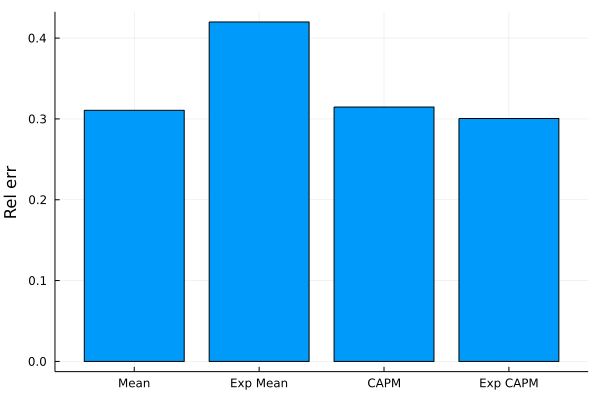

In [6]:
num_rows = nrow(returns)

past_returns = Matrix(returns[1:div(num_rows, 2), :])
future_returns = Matrix(returns[(div(num_rows, 2)+1):end, :])

mean_future_rets = ret_model(MRet(), future_returns)

mean_ret = ret_model(MRet(), past_returns)
exp_mean_ret = ret_model(EMRet(), past_returns, span=num_rows / 2)
capm_ret = ret_model(CAPMRet(), past_returns)
exp_capm_ret =
    ret_model(ECAPMRet(), past_returns, cspan=num_rows / 2, rspan=num_rows / 2)

errors = Float64[]
push!(errors, sum(abs.(mean_future_rets - mean_ret)))
push!(errors, sum(abs.(mean_future_rets - exp_mean_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret)))
push!(errors, sum(abs.(mean_future_rets - exp_capm_ret)))

errors /= length(mean_future_rets)

println(errors)

fig = bar(
    ["Mean", "Exp Mean", "CAPM", "Exp CAPM"],
    errors,
    ylabel="Rel err",
    legend=false,
)

Returns are chaotic and unpredictable, so it's often better to optimise portfolios without considering returns. The average absolute errors are all over 30%, so for this case, a portfolio that has an expected return of 10 %, will most likely return between [-20, 40] %.

Minimum volatility, semivariance, CVaR and CDaR tend to give more stable portfolios than ones that take returns into consideration.

We can plot all the return types together to see how they correlate to each other.

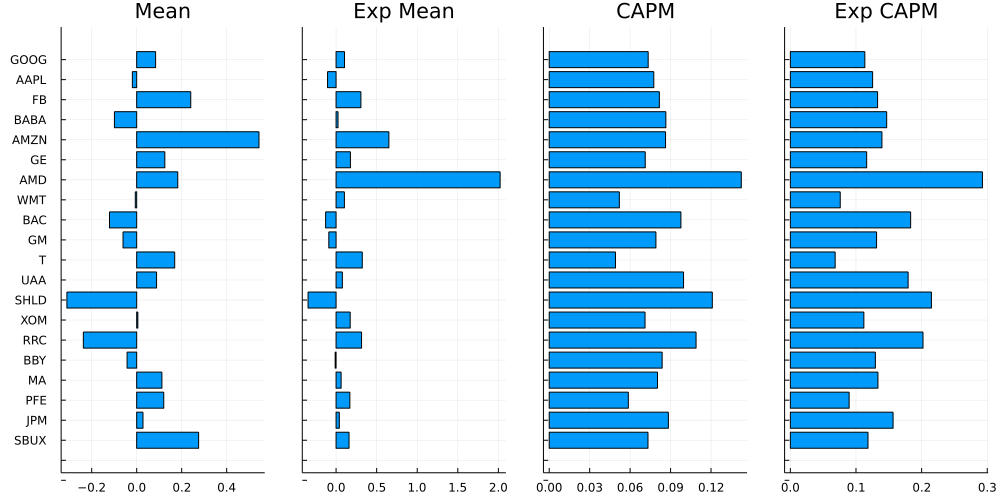

In [7]:
l = @layout [a b c d]

fig1 = bar(
    mean_ret,
    yticks = (1:num_rows, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "Mean",
)

fig2 = bar(
    exp_mean_ret,
    yticks = (1:num_rows, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "Exp Mean",
)

fig3 = bar(
    capm_ret,
    yticks = (1:num_rows, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM",
)

fig4 = bar(
    exp_capm_ret,
    yticks = (1:num_rows, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "Exp CAPM",
)

plot(fig1, fig2, fig3, fig4, layout = l, size = (1000, 500))

There's strong correspondence between exponential and non-exponentially weighted return types. CAPM returns are a little bit different as they account for an asset's relationship to the market via a covariance matrix.

## Risk models

We also have a few built-in risk models. For more models see [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl).

We provide a variety of covariance measures:

- sample covariance
- exponentially weighted sample covariance
- semicovariance
- exponentially weighted semicovariance

The optional keyword arguments are further explained in the docs.

[0.04827333795084753, 0.0628297583608334, 0.022906141382702475, 0.024828750906271832]


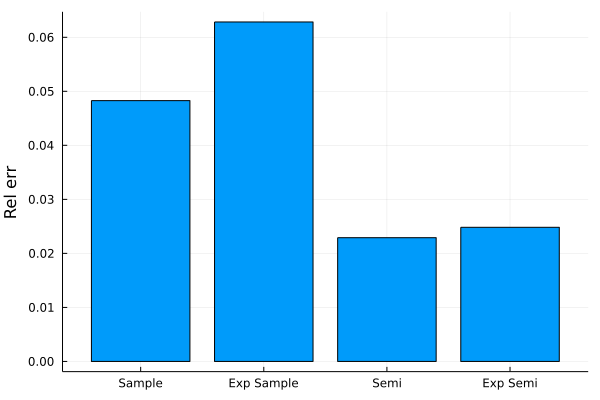

In [8]:
future_cov = risk_matrix(Cov(), future_returns)
future_semi_cov = risk_matrix(SCov(), future_returns)

sample_cov = risk_matrix(Cov(), past_returns)
exp_cov = risk_matrix(ECov(), past_returns, span=num_rows / 2)
semi_cov = risk_matrix(SCov(), past_returns)
exp_semi_cov = risk_matrix(ESCov(), past_returns, span=num_rows / 2)

future_var = diag(future_cov)
future_semivar = diag(future_semi_cov)

errors = Float64[]
push!(errors, sum(abs.(future_var - diag(sample_cov))))
push!(errors, sum(abs.(future_var - diag(exp_cov))))
push!(errors, sum(abs.(future_semivar - diag(semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(exp_semi_cov))))

errors /= length(future_var)

println(errors)

fig = bar(
    ["Sample", "Exp Sample", "Semi", "Exp Semi"],
    errors,
    ylabel="Rel err",
    legend=false,
)

This is a toss up, as the non exponentially weighted covariances did a better job of estimating the correlations between assets than the corresponding exponentially weighted ones.

Furthermore, this lends more weight to the concept of using optimisations which account for downside risk such as MeanSemivar, CVaR and CDaR optimisations, and using the semicovariance as the input covariance matrix for Black-Litterman and Hierarchical Risk Parity optimisations.

We can do the same for the covariances, which is what the optimisations actually use.

[0.01518933619679906, 0.018065888491026704, 0.00834274907785078, 0.009577873267378257]


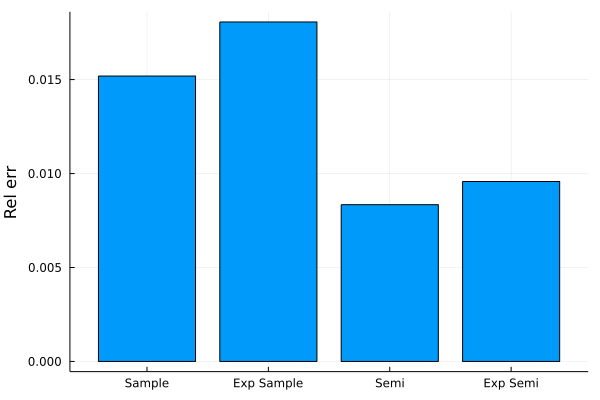

In [9]:
errors = Float64[]
push!(errors, sum(abs.(future_cov - sample_cov)))
push!(errors, sum(abs.(future_cov - exp_cov)))
push!(errors, sum(abs.(future_semi_cov - semi_cov)))
push!(errors, sum(abs.(future_semi_cov - exp_semi_cov)))

errors /= length(future_cov)

println(errors)

fig = bar(
    ["Sample", "Exp Sample", "Semi", "Exp Semi"],
    errors,
    ylabel = "Rel err",
    legend = false,
)

Again, this is a bit of a toss up between choosing exponentially weighted vs not, but the estimation error is again lower when using semicovariances.

If we plot the absolute errors of the correlation matrices we can see that the semicovariance is a more stable measure of the correlation between assets, note how much darker the second plot is compared to the first.

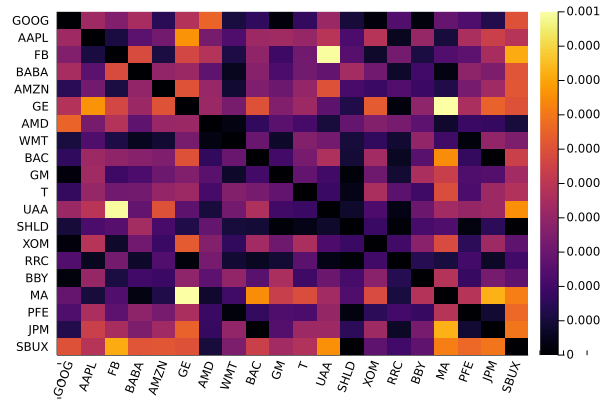

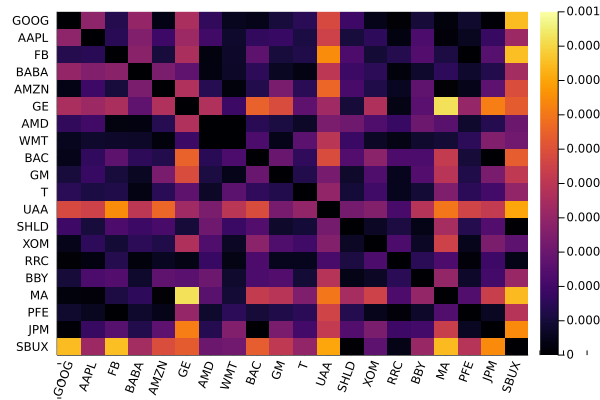

In [10]:
fig1 = heatmap(
    abs.(cov2cor(future_cov) - cov2cor(sample_cov)) / length(future_cov),
    yflip = true,
    xticks = (1:num_rows, names(returns)),
    yticks = (1:num_rows, names(returns)),
    xrotation = 70,
    clims = (0, 1e-3),
)

fig2 = heatmap(
    abs.(cov2cor(future_semi_cov) - cov2cor(semi_cov)) / length(future_semi_cov),
    yflip = true,
    xticks = (1:num_rows, names(returns)),
    yticks = (1:num_rows, names(returns)),
    xrotation = 70,
    clims = (0, 1e-3),
)

display(fig1)
display(fig2)